In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
np.set_printoptions(precision = 3, suppress = True)

In [3]:
import tensorflow as tf

2023-04-11 12:09:37.985649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
url = 'https://raw.githubusercontent.com/diazrenata/feasible-catch/main/keras/fs_data.csv'


raw_dataset = pd.read_csv(url)

In [6]:
raw_dataset.tail()

,richness,abundance,mean,sd
412,199,350,111.391484,12.139175
413,199,450,93.803156,12.136935
414,199,550,84.827134,12.084486
415,199,2350,79.866647,11.545702
416,199,15950,113.122693,7.540130


In [7]:
dataset = raw_dataset.copy()

dataset.isna().sum()

dataset = dataset.drop(columns ='sd')

In [8]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)

test_dataset = dataset.drop(train_dataset.index)

In [9]:
train_dataset.head()

,richness,abundance,mean
409,198,250,154.813451
170,96,150,64.892904
224,117,150,92.893666
390,190,15250,108.870715
308,159,250,101.077303


In [10]:
test_dataset.head()

,richness,abundance,mean
9,10,750,6.943562
25,20,50,13.749272
28,21,150,13.454636
31,22,250,14.203066
32,22,1750,14.632487


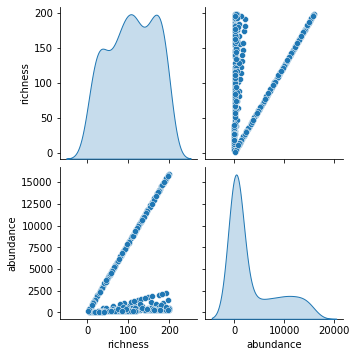

In [11]:
sns.pairplot(train_dataset[['richness', 'abundance']], diag_kind = 'kde')

^^ this is weird partially beacuse of the distribution of sampled space

In [12]:
train_dataset.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
richness,334.0,108.410180,57.094906,2.000000,62.000000,111.500000,159.000000,199.000000
abundance,334.0,3453.892216,4811.661554,50.000000,250.000000,450.000000,6425.000000,15950.000000
mean,334.0,64.057431,35.012331,1.655962,36.467109,62.850225,88.388909,156.101279


In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("mean")
test_labels = test_features.pop("mean")

Here the tutorial normalizes the features. It's suggested this is _important_ because of the model weighting. I instinctively hesitate, so this may be a point to test further. 

In [14]:
normalizer = tf.keras.layers.Normalization(axis = -1)

In [15]:
normalizer.adapt(np.array(train_features))

2023-04-11 12:09:40.923420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
print(normalizer.mean.numpy())

[[ 108.41  3453.892]]


In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print() 
    print('Normalized', normalizer(first).numpy())

First example: [[198 250]]

Normalized [[ 1.57 -0.67]]


Sidebar - yeah, this normalization is going to be weird as the sampled sxn space changes.

## Linear regression

In [18]:
rich = np.array(train_features['richness'])

So this looks to me like normalization is happening independent of the earlier normalization step...

In [19]:
rich_normalizer = layers.Normalization(input_shape = [1, ], axis = None)

In [20]:
rich_normalizer.adapt(rich)

Building a "sequential" model:

In [21]:
rich_model = tf.keras.Sequential([
    rich_normalizer,
    layers.Dense(units = 1)
])

In [22]:
rich_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [23]:
 rich_model.predict(rich[:10])

1/1 [==============================] - 0s 47ms/step


array([[ 2.644],
       [-0.366],
       [ 0.254],
       [ 2.408],
       [ 1.493],
       [ 1.464],
       [-0.632],
       [-2.875],
       [-2.698],
       [ 0.785]], dtype=float32)

In [24]:
rich_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error')

In [25]:
%%time
history = rich_model.fit(
    train_features['richness'],
    train_labels,
    epochs = 500,
    verbose = 0,
    validation_split = .2)

CPU times: user 11.1 s, sys: 868 ms, total: 11.9 s
Wall time: 10.2 s


In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
495,8.108043,9.086402,495
496,8.106280,9.090688,496
497,8.106636,9.094730,497
498,8.107696,9.110651,498
499,8.106747,9.095662,499


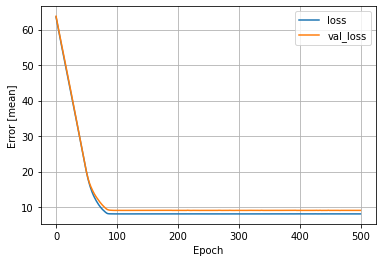

In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [mean]')
  plt.legend()
  plt.grid(True)
plot_loss(history)


In [28]:
test_results = {}

test_results['rich_model'] = rich_model.evaluate(
    test_features['richness'],
    test_labels, verbose = 0)

In [29]:
x = tf.linspace(0.0, 250, 251)
y = rich_model.predict(x)


8/8 [==============================] - 0s 552us/step


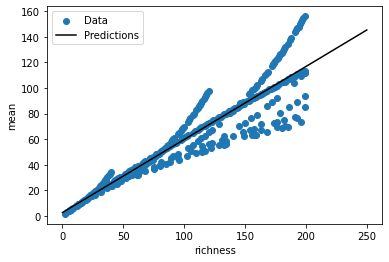

In [30]:
def plot_rich(x, y):
  plt.scatter(train_features['richness'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('richness')
  plt.ylabel('mean')
  plt.legend()
plot_rich(x, y)


Ok, this is a familiar plot with a familiar (very bad) regression. That is expected.

## Linear reg with multiple inputs

Ok, so _here_ we're actually using the normalizer we set up and "adapted" to the training features earlier.

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units = 1) #what does this do?
])

In [32]:
linear_model.predict(train_features[:10])


1/1 [==============================] - 0s 33ms/step


array([[ 0.969],
       [ 0.111],
       [ 0.289],
       [-0.08 ],
       [ 0.639],
       [-0.181],
       [-0.41 ],
       [-0.603],
       [-0.637],
       [-0.259]], dtype=float32)

In [33]:
linear_model.layers[1].kernel


<tf.Variable 'dense_1/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 0.483],
       [-0.314]], dtype=float32)>

In [34]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [35]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


CPU times: user 2.47 s, sys: 201 ms, total: 2.67 s
Wall time: 2.29 s


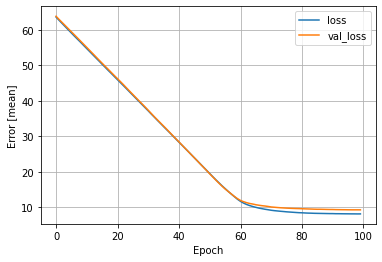

In [36]:
plot_loss(history)

In the example, this one does better than the single regression. Not so much for this - still bottoming out around a loss of 10.

I guess this shouldn't surprise me too much.


In [37]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)


## DNN


In [38]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation = 'relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss = 'mean_absolute_error',
                 optimizer = tf.keras.optimizers.Adam(0.001))
    return model

### Single input DNN

In [39]:
dnn_rich_model = build_and_compile_model(rich_normalizer)

In [40]:
dnn_rich_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [41]:
%%time
history = dnn_rich_model.fit(
    train_features['richness'],
    train_labels,
    validation_split = 0.2,
    verbose = 0, epochs = 100)

CPU times: user 2.82 s, sys: 251 ms, total: 3.07 s
Wall time: 2.51 s


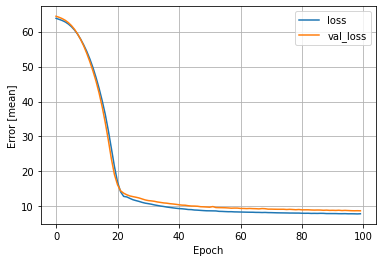

In [42]:
plot_loss(history)

Lol, still not very good.... (this is just richness but allowed to be nonlinear, I think)

8/8 [==============================] - 0s 681us/step


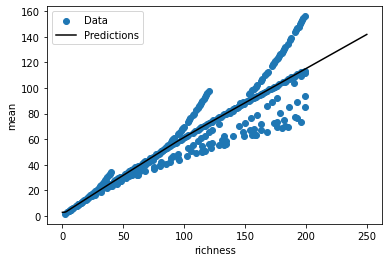

In [43]:
x = tf.linspace(0.0, 250, 251)
y = dnn_rich_model.predict(x)
plot_rich(x, y)

In [46]:
test_results['dnn_rich_model'] = dnn_rich_model.evaluate(
    test_features['richness'], test_labels,
    verbose=0)


Huh, I guess maybe it's still doing a poor job fitting because it's not that it's an intriniscally/heavily weighted nonlinear relationship (as compared to, for example, the horsepower one in the example) so much as it is highly highly contingent | abundance. Meaning adding abund should make it better?


In [54]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 64)                192       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,422
Trainable params: 4,417
Non-trainable params: 5
_________________________________________________________________


In [55]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


CPU times: user 2.83 s, sys: 229 ms, total: 3.05 s
Wall time: 2.54 s


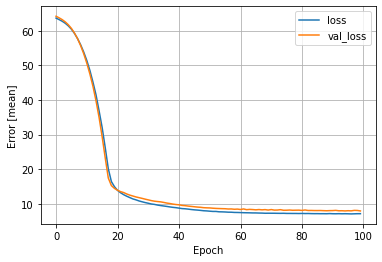

In [56]:
plot_loss(history)


In [57]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [58]:
pd.DataFrame(test_results, index=['Mean absolute error [mean]']).T


,Mean absolute error [mean]
rich_model,9.110812
linear_model,8.527544
dnn_rich_model,8.906281
dnn_model,7.610375


Pausing before 'Make predictions'.